In [5]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
#import tensorflow as tf
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary


import sympy as sym
import json
import matplotlib.pyplot as plt
#from tensorflow.keras import layers, models, initializers
from utils import *

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train, )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([256, 3, 32, 32])


In [8]:
# Solve simbolically for number of units in the first layer, given number of inputs, outputs and the number of units in the first layer
# number_of_params =  input_param*u1+u1 + u1*u2+u2 + u2*output_param+ output_param   #u_i : number of units at layer i

p = sym.Symbol('p')
i = sym.Symbol('i')
u1 = sym.Symbol('u1')
u2 = sym.Symbol('u2')
u3 = sym.Symbol('u3')

sym.solveset((i*u1 + u1)+ (u1*u2 + u2) + ( u2*u3+ u3) - p, u2)

FiniteSet((-i*u1 + p - u1 - u3)/(u1 + u3 + 1))

In [94]:
def compute_layers_first_unit(p, input_dim, u2, u3):
    num = (p-u2*u3-u2-u3)
    den = (input_dim + u2 +1)
    u1 = int(np.round(num/den))

    assert u1 >= 1, 'u1 must be >= 1, reduce second unit or increase number or params'
   # print((input_dim*u1 + u1)+ (u1*u2 + u2) + ( u2*u3+ u3))
  
    return [u1, u2, u3]

In [93]:
def compute_layers_second_unit(p, input_dim, u1, u3):
    num = (-1*input_dim*u1+p-u1-u3)
    den = (u1 +u3 +1)
    u2 = int(np.round(num/den))

    assert u2 >= 1, 'u1 must be >= 1, reduce second unit or increase number or params'
   # print((input_dim*u1 + u1)+ (u1*u2 + u2) + ( u2*u3+ u3))
    
    return [u1, u2, u3]

Default initialization of Linear layers = init.kaiming_uniform_(self.weight, a=math.sqrt(5)) 
<br>
uses default nonlinearity = leaky_relu, which leads to gain = \sqrt{\frac{2}{1 + a^2} = sqrt(1/3), 
std = gain / math.sqrt(fan) = sqrt(1/3) / math.sqrt(fan)
bound = math.sqrt(3.0) * std) =  math.sqrt(3.0) sqrt(1/3) / math.sqrt(fan) = 1/sqrt(fan)
uniform(-bound, bound)

<br>
    
equivalent to  initializing with  uniform(-1/sqrt(in_features), 1/sqrt(in_features)), i.e.

<br>

$$ \mathcal{U}(-\sqrt{k}, \sqrt{k})$$ 
where
$$ k = \frac{1}{\text{in\_features}}$$

Pytorch kaiming uniform with relu nonlinearity:

$$ \mathcal{U}(-\sqrt{k}, \sqrt{k})$$ 
where
$$ k = \text{gain}^2*\frac{3}{\text{fan\_mode}} = \frac{2 * 3}{\text{in\_features}}  $$ 

<br>
with gain= $\sqrt{2}$ for ReLU ( https://github.com/pytorch/pytorch/blob/7fbcf796842442fb79a7b007a2494c798e88602f/torch/nn/init.py#L81)

<br>

In "How to Start Training: The Effect of Initialization and Architecture":

 "at the time of writing, the Keras (and Pytorch) implementation truncates
the normal distribution at two standard deviations from the mean." 

<br>

However, in the pytorch source code, we see that the uniform distribution is not truncated:
 https://github.com/pytorch/pytorch/blob/3596e13d45d8a69ae83dd2f260b2fa8b8376f182/torch/nn/init.py#L125


In [7]:
def pytorchs_kaiming_uniform_(a=0):
    '''Args:
        tensor: an n-dimensional `torch.Tensor`
        a: the negative slope of the rectifier used after this layer (only
            used with ``'leaky_relu'``)
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
            forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
            backwards pass.
        nonlinearity: the non-linear function (`nn.functional` name),
            recommended to use only with ``'relu'`` or ``'leaky_relu'`` (default).
'''
    fan = _calculate_correct_fan(tensor, mode)
    gain = calculate_gain(nonlinearity, a) #if relu will return  sqrt(2)#https://github.com/pytorch/pytorch/blob/3596e13d45d8a69ae83dd2f260b2fa8b8376f182/torch/nn/init.py#L108
    std = gain / math.sqrt(fan)
    bound = math.sqrt(3.0) * std  # Calculate uniform bounds from standard deviation
    with torch.no_grad():
        return tensor.uniform_(-bound, bound)

In "How to Start Training: The Effect of Initialization and Architecture": 

"The mean E[Md] of the normalized output length is equal to the input length if network weights are drawn independently from a symmetric
distribution with variance 2/fan-in."

<bs>
"It is worth noting that the 2 in our optimal variance 2/fan-in arises from the ReLU, which zeros
out symmetrically distributed input with probability 1/2, thereby effectively halving the variance at
each layer. (For linear activations, the 2 would disappear.)"

std = sqrt(2)/sqrt(feature_in)

This means, we should consider

In [8]:
# In experiment results: 
# 
# he_uniform_fanin = nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu') = var=6/fanin

# no mention to init=default = 1/fanin

In [37]:
class Net(nn.Module):
    def __init__(self, input_dim, units):
        u1, u2, u3 =  units[0], units[1], units[2]
        super().__init__()
        self.fc1 = nn.Linear(input_dim, u1)
        nn.init.kaiming_uniform_(self.fc1.weight, a= np.sqrt(2), mode='fan_in', nonlinearity='leaky_relu')
        self.fc2 = nn.Linear(u1, u2)
        nn.init.kaiming_uniform_(self.fc2.weight, a= np.sqrt(2), mode='fan_in', nonlinearity='leaky_relu')
        self.fc3 = nn.Linear(u2, u3)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net(3*32*32, layers_units)

summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 5]          15,365
            Linear-2                 [-1, 1000]           6,000
            Linear-3                   [-1, 10]          10,010
Total params: 31,375
Trainable params: 31,375
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 0.12
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [29]:
k = 2/ (3072) # to avoid FM1 
my_weights= np.random.uniform(-np.sqrt(k), np.sqrt(k), size=(9*3072))
#plt.hist(my_weights)
print(np.std(my_weights))

print(net.fc1.weight.detach().numpy().shape)
#plt.hist(net.fc1.weight.detach().numpy().flatten())
print( np.std(net.fc1.weight.detach().numpy()))

0.014756159488369351
(9, 3072)
0.010445603


In [30]:
k = 1/ (3072) #default
my_weights= np.random.uniform(-np.sqrt(k), np.sqrt(k), size=(9*3072))
#plt.hist(my_weights)
print(np.std(my_weights))

print(net.fc1.weight.detach().numpy().shape)
#plt.hist(net.fc1.weight.detach().numpy().flatten())
print( np.std(net.fc1.weight.detach().numpy()))

0.010419204894223204
(9, 3072)
0.010445603


In [ ]:
k = 6/ (3072) #he_uniform_fanin
my_weights= np.random.uniform(-np.sqrt(k), np.sqrt(k), size=(5*3072))
#plt.hist(my_weights)
#plt.show()
print(np.std(my_weights))

print(net.fc1.weight.detach().numpy().shape)
#plt.hist(net.fc1.weight.detach().numpy().flatten())
print( np.std(net.fc1.weight.detach().numpy()))


0.02560202085904611
(5, 3072)
0.025321193


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [32]:
def rename_file(filename):
    if len(filename.split('_0.1lr_200Tmax'))>1:
        print('file already renamed:',filename)
    else:
        print('rename')
        print(filename)
        [part0, part1] = filename.split('_0.1lr')
        new_name = part0+'_0.1lr_200Tmax'+part1
        print(new_name)
        os.rename(filename, new_name)
    return

In [9]:
def load_checkpoint(model, optimizer, scheduler, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        loss = checkpoint['loss']
        val_loss = checkpoint['val_loss']
        acc = checkpoint['acc']
        val_acc = checkpoint['val_acc']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, scheduler, start_epoch, loss, val_loss, acc, val_acc

In [34]:
def train(epoch, net, optimizer,criterion):
    net.train()
    loss, total, correct = 0.0 ,0.0 ,0.0

    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels) #loss value on batch
        loss.backward()
        optimizer.step()

        loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()   #predicted.eq(targets)

    return loss/total, correct/total

In [10]:
def test(epoch, net, criterion):
    net.eval()
    val_loss, val_total, val_correct = 0.0 ,0.0 ,0.0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    return val_loss/val_total, val_correct/val_total

In [36]:
'''def train_models(n_param, layers_units, epcs, verb_epc, reload_model_path, reload=True): 

    net=Net(3*32*32, layers_units)
    criterion = nn.CrossEntropyLoss()
    T_max0 =10
    Tmul =2
    T_max = T_max0
    optimizer = optim.SGD(net.parameters(), lr=lr) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=- 1, verbose=False)   

    if reload ==True:
        net, optimizer, scheduler, start_epc, losses, val_losses, accs, val_accs = load_checkpoint(net, optimizer, scheduler, filename=reload_model_path)
        net.load_state_dict(torch.load(reload_model_path), strict=False)
        start_epc = int(reload_model_path.split('epcs')[0].split('_')[-1])
        print('** start_epc',start_epc)
    else:
        start_epc=0
        print('** start_epc',start_epc)
        losses, val_losses= [], []
        accs, val_accs = [], []
        
    for epoch in range(start_epc, start_epc+epcs): 

        loss, acc = train(epoch, net, optimizer, criterion)
        val_loss, val_acc = test(epoch, net, criterion)
        scheduler.step()

        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if (epoch+1)%verb_epc==0:
            print('\n epoch', epoch+1)
            print('accuracy',accs[-1])  
            print('val_accuracy',val_accs[-1])

        if (epoch+1)%T_max==0:
            print('\n epoch', epoch+1)
            T_max*=Tmul # https://arxiv.org/pdf/1608.03983.pdf In order to improve performance, start with an initially small Ti and increase it by a factor of Tmult at every restart
            optimizer = optim.SGD(net.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=- 1, verbose=False)
            #print(optimizer.state_dict())
            print(scheduler.state_dict())

        if (epoch+1)%verb_epc*2==0 or (epoch+1)%300==0 :
            state = {'epoch': epoch + 1, 'state_dict': net.state_dict(),
                    'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict(), 'loss': losses, 'val_loss': val_losses,
                    'val_acc': val_accs, 'acc': accs}
            torch.save(state, local_path+'pytorch_cifar10_he_uniform_fm1_{}p_{}_{}lr_{}T0_{}Tmul_{}bs_{}epcs'.format(n_param, str(layers_units), lr, T_max0, Tmul, batch_size, start_epc+epcs)   )

    state = {'epoch': epoch + 1, 'state_dict': net.state_dict(),
                    'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict(), 'loss': losses, 'val_loss': val_losses,
                    'val_acc': val_accs, 'acc': accs}
    torch.save(state, local_path+'pytorch_cifar10_he_uniform_fm1_{}p_{}_{}lr_{}T0_{}Tmul_{}bs_{}epcs'.format(n_param, str(layers_units), lr, T_max0, Tmul, batch_size, start_epc+epcs)   )
      
    return losses, val_losses, accs, val_accs'''


In Are wider nets better: "We conjecture that the kernel of a finite-width network at initialization is indicative of its performance, and that optimal performance
is achieved when its distance to the infinite-width kernel is minimized."

In How to Start Training: The Effect of Initialization and Architecture:  (FM2 for fully connected networks (informal)). The mean of the empirical
variance for the lengths of activations in a fully connected ReLU net is exponential in Sum(1/nj)

Could we formulate all stability analysis in terms of the (distance) infinite-width kernel?

In [22]:
local_path = '/home/mm/research/bottleneck_experiments/results/'

n_param = 30000
epcs=300
lr = 0.05
start_epoch = 0
verb_epc = 30
reload= False
'''loss_dict, val_loss_dict, acc_dict, val_acc_dict = {}, {}, {}, {}
for u2 in [100]:
    layers_units = compute_layers_first_unit(n_param, 3*32*32, u2, 10)
    print(layers_units) 
    reload_model_path =''#'pytorch_cifar10_he_uniform_fm1_{}p_{}_{}lr_{}T0_{}Tmul_{}bs_{}epcs'.format(n_param, str(layers_units), lr, T_max0, Tmul, batch_size,start_epoch)   
    loss, val_loss, acc, val_acc = train_models(n_param, layers_units, epcs, verb_epc, reload_model_path, reload)
    loss_dict[str(layers_units)] = loss
    val_loss_dict[str(layers_units)] = val_loss
    acc_dict[str(layers_units)] =  acc
    val_acc_dict[str(layers_units)] =  val_acc
    '''

"loss_dict, val_loss_dict, acc_dict, val_acc_dict = {}, {}, {}, {}\nfor u2 in [100]:\n    layers_units = compute_layers_first_unit(n_param, 3*32*32, u2, 10)\n    print(layers_units) \n    reload_model_path =''#'pytorch_cifar10_he_uniform_fm1_{}p_{}_{}lr_{}T0_{}Tmul_{}bs_{}epcs'.format(n_param, str(layers_units), lr, T_max0, Tmul, batch_size,start_epoch)   \n    loss, val_loss, acc, val_acc = train_models(n_param, layers_units, epcs, verb_epc, reload_model_path, reload)\n    loss_dict[str(layers_units)] = loss\n    val_loss_dict[str(layers_units)] = val_loss\n    acc_dict[str(layers_units)] =  acc\n    val_acc_dict[str(layers_units)] =  val_acc\n    "

In [95]:
def aggregate_metrics(layers_units, epcs):
    filename = local_path+'pytorch_cifar10_he_uniform_fm1_{}p_{}_{}lr_{}bs_{}epcs'.format(n_param, str(layers_units), lr, batch_size, epcs)
    #filename = local_path+'pytorch_cifar10_he_uniform_fm1_{}p_{}_{}lr_{}T0_{}Tmul_{}bs_{}epcs'.format(n_param, str(layers_units), lr, T_max0, Tmul, batch_size,epcs)
    if os.path.isfile(filename):
       # print("loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        losses = checkpoint['loss']
        val_losses = checkpoint['val_loss']
        accs = checkpoint['acc']
        val_accs = checkpoint['val_acc']
    else:
        print("checkpoint not found '{}'".format(filename))
    return losses, val_losses, accs, val_accs


def compare_aggregated_metrics(layers_units, n_param):
    epcs=400
    T_max=400
    lr=0.05
    files, keys, layers = [], [], []
    for n_param  in [n_param]:
        files.append(local_path+'pytorch_cifar10_he_uniform_fm1_default_BN_{}p_{}_{}lr_{}Tmax_{}bs_{}epcs'.format(n_param, str(layers_units), lr, T_max, batch_size, epcs))
        #files.append(local_path+'pytorch_cifar10_xavier_uniform_fm1_default_BN_{}p_{}_{}lr_{}Tmax_{}bs_{}epcs'.format(n_param, str(layers_units), lr, T_max, batch_size, epcs))
      #  files.append(local_path+'pytorch_cifar10_he_uniform_fm1_{}p_{}_{}lr_{}Tmax_{}bs_{}epcs'.format(n_param, str(layers_units), lr, T_max, batch_size, epcs))
    
        keys.append(['he_uniform_BN_'+str(n_param)])#, 'xavier_uniform_BN_'+str(n_param)])#, 'he_uniform_'+str(n_param)])

    keys = [key for sublist in keys for key in sublist]
    losses, val_losses, accs, val_accs = {} ,{}, {} ,{}

    for i in range(len(keys)):

        if os.path.isfile(files[i]):
        # print("loading checkpoint '{}'".format(filename))
            checkpoint = torch.load(files[i])
            losses['loss '+str(keys[i])] = checkpoint['loss']
            val_losses['val_loss '+str(keys[i])] = checkpoint['val_loss']
            accs['acc '+str(keys[i])] = checkpoint['acc']
            val_accs['val_acc '+str(keys[i])] = checkpoint['val_acc']
            
        else:
            print("checkpoint not found '{}'".format(files[i]))
    return losses, val_losses, accs, val_accs


In [96]:
def plot_metrics(metrics_list):
    losses, val_losses, accs, val_accs = metrics_list
    labels = ['train', 'test']
    i=0
    metrics = [accs, val_accs, losses, val_losses]
    metric_names = ['acc', 'loss']
    for i in range(0,4,2):       
        plt.plot(metrics[i], label= '{} {} - {}'.format(labels[0], metric_names[i%2], str(layers_units)))
        plt.plot(metrics[i+1], label= '{} {} - {}'.format(labels[1], metric_names[i%2+1], str(layers_units)))
        plt.legend()
        plt.show()
        i+=1
    return 

def comparative_plot(metric_dict, layers_units, n_param):
    for key in metric_dict.keys():
        label= key.split(' ')[1]#+key.split(' ')[2]
        plt.plot(metric_dict[key], label= label)
        plt.title(key.split(' ')[0]+' - '+str(n_param)+' - '+str(layers_units))
    plt.legend()
    return

In [81]:
def compute_n_param(u0, layers_units):
    [u1, u2, u3] = layers_units
    p0=u0*u1+u1
    p1=u1*u2+u2
    p2=u2*u3+u3
    return p0+p1+p2

compute_n_param(3072, [13,1,10])

39983

In [61]:
val_losses[list(val_losses.keys())[-1]][-1]
list(val_losses.keys())[-1]

'val_loss xavier_uniform_BN_60000'

In [82]:
local_path = '/home/mm/research/bottleneck_experiments/results/'

test_losses, test_accs = {},{}
for n_param in [4*10**4, 6*10**4]:
    final_test_losses, final_test_accs = [], []
    for u2 in [1, 10, 100, 500, 1000]:
        layers_units = compute_layers_first_unit(n_param, 3*32*32, u2, 10)
        #print('\n layers_units', layers_units)
        metrics_dicts = compare_aggregated_metrics(layers_units, n_param)
        _, val_losses, _, val_accs = metrics_dicts
        
        for val_loss in val_losses:
            final_test_losses.append(val_losses[val_loss][-1])
        for val_acc in val_accs:
            final_test_accs.append(val_accs[val_acc][-1])

        test_losses[n_param]=final_test_losses
        test_accs[n_param]=final_test_accs

39983
40199
39186
41240
39521
61501
58697
61397
59105
59886


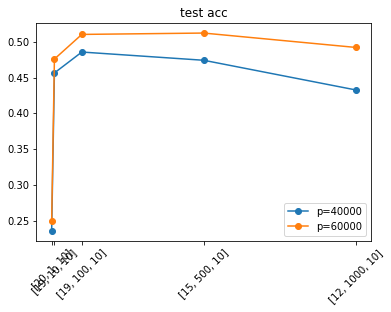

In [113]:
u2_list = [1, 10, 100, 500, 1000]

for p in [4*10**4, 6*10**4]:
    annotations = [str(compute_layers_first_unit(p, 3*32*32, u2, 10)) for u2 in u2_list]
    plt.plot(u2_list, test_accs[p], '-o', label='p='+str(p))
    
plt.title('test acc')
plt.xticks(u2_list, annotations, rotation=45)
plt.legend()
plt.show()


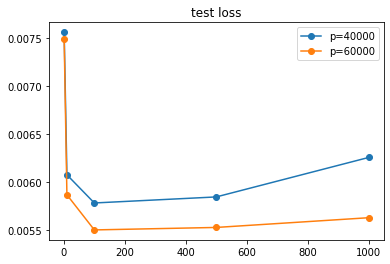

In [114]:
u2_list = [1, 10, 100, 500, 1000]

for p in [4*10**4, 6*10**4]:
    annotations = [str(compute_layers_first_unit(p, 3*32*32, u2, 10)) for u2 in u2_list]
    plt.plot(u2_list, test_losses[p], '-o', label='p='+str(p))
    
plt.title('test loss')
#plt.xticks(u2_list, annotations, rotation=45)
plt.legend()
plt.show()


In [63]:
#n_param = 40000 #3*10**4]:#, 4*10**4, 6*10**4, 8*10**4
local_path = '/home/mm/research/bottleneck_experiments/results/'


for n_param in [4*10**4, 6*10**4]:
    final_test_losses, final_test_accs = [], []
    for u2 in [1, 10, 100, 500, 1000]:
        layers_units = compute_layers_first_unit(n_param, 3*32*32, u2, 10)
        print('\n layers_units', layers_units)
        metrics_dicts = compare_aggregated_metrics(layers_units, n_param)
        _, val_losses, _, val_accs = metrics_dicts
        
        for val_loss in val_losses:
            final_test_losses.append(val_loss[list(val_losses.keys())[-1]][-1])
        for val_loss in val_losses:
            final_test_accs.append(val_accs[list(val_accs.keys())[-1]][-1])


        for metric_dict in metrics_dicts:
            n_param_true = compute_n_param(3072, layers_units)
            comparative_plot(metric_dict, layers_units, n_param_true)
            plt.show()
            

39983

 layers_units [13, 1, 10]
checkpoint not found '/home/mm/research/bottleneck_experiments/results/pytorch_cifar10_he_uniform_fm1_40000p_[13, 1, 10]_0.05lr_400Tmax_256bs_400epcs'


TypeError: string indices must be integers

30761

 layers_units [10, 1, 10]


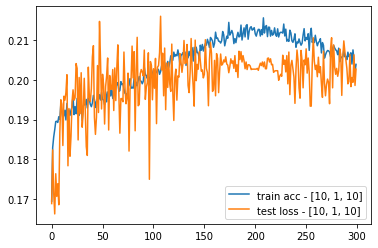

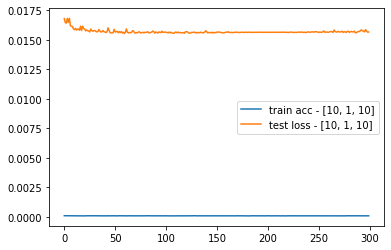

30950

 layers_units [10, 10, 10]


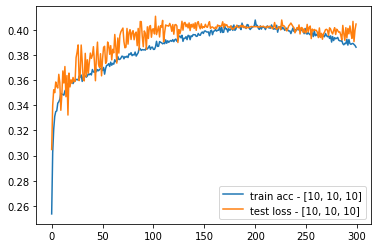

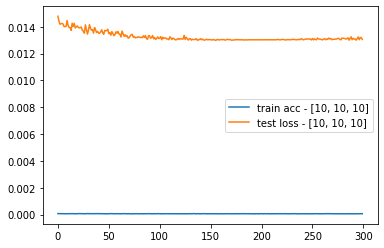

29667

 layers_units [9, 100, 10]


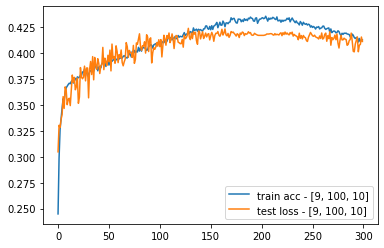

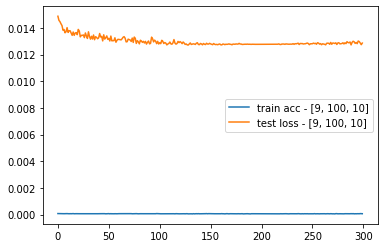

30521

 layers_units [7, 500, 10]


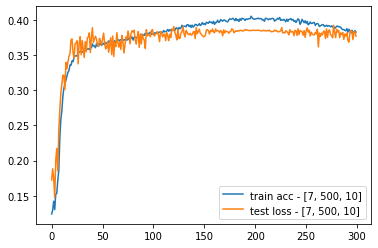

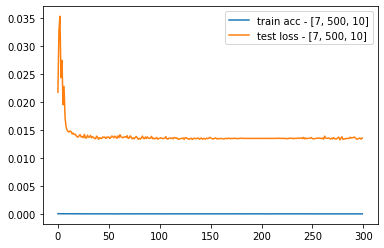

31375

 layers_units [5, 1000, 10]
checkpoint not found '/home/mm/research/bottleneck_experiments/results/pytorch_cifar10_he_uniform_fm1_30000p_[5, 1000, 10]_0.1lr_128bs_300epcs'


UnboundLocalError: local variable 'losses' referenced before assignment

In [ ]:
lr = 0.1
for u2 in [1, 10, 100, 500, 1000]:
    layers_units = compute_layers_first_unit(n_param, 3*32*32, u2, 10)
    print('\n layers_units', layers_units)
    metrics_list = aggregate_metrics(layers_units, epcs)
    plot_metrics(metrics_list)

30761

 layers_units [10, 1, 10]


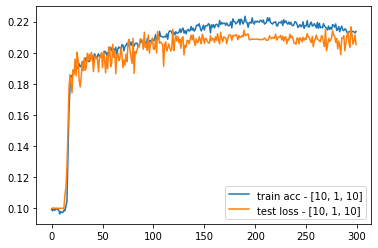

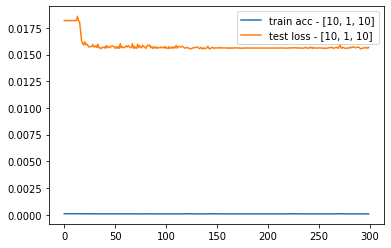

30950

 layers_units [10, 10, 10]


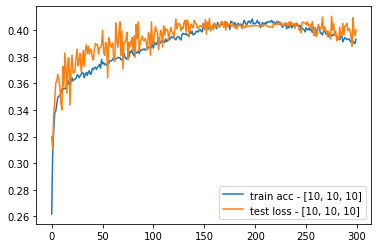

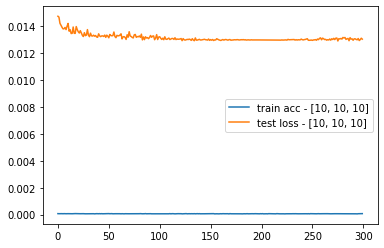

29667

 layers_units [9, 100, 10]


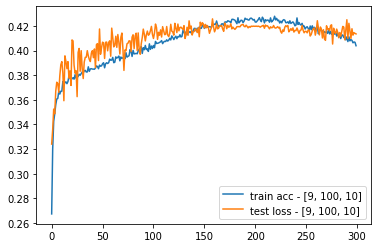

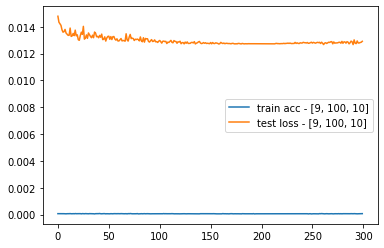

30521

 layers_units [7, 500, 10]


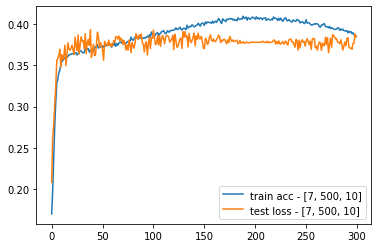

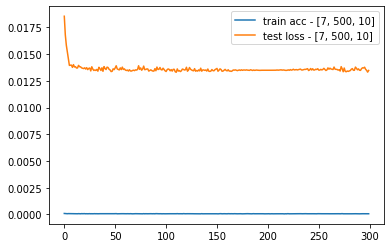

31375

 layers_units [5, 1000, 10]


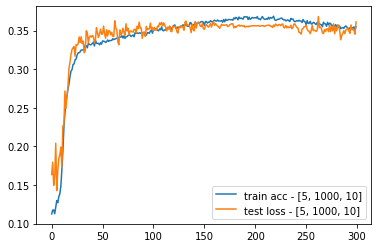

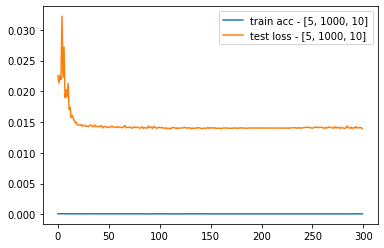

In [ ]:
lr = 0.1
for u2 in [1, 10, 100, 500, 1000]:
    layers_units = compute_layers_first_unit(n_param, 3*32*32, u2, 10)
    print('\n layers_units', layers_units)
    metrics_list = aggregate_metrics(layers_units, epcs)
    plot_metrics(metrics_list)

30761

 layers_units [10, 1, 10]


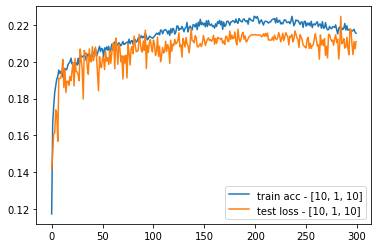

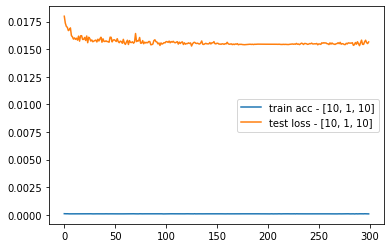

30950

 layers_units [10, 10, 10]


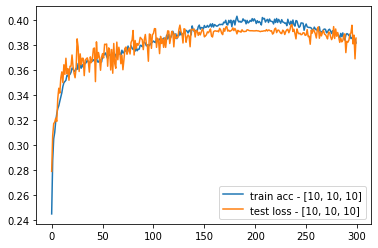

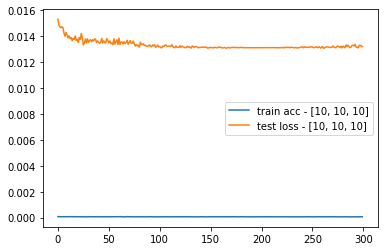

29667

 layers_units [9, 100, 10]


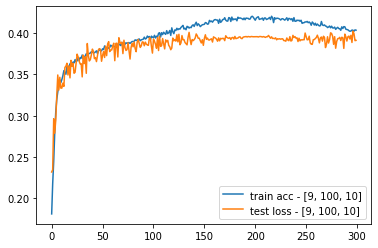

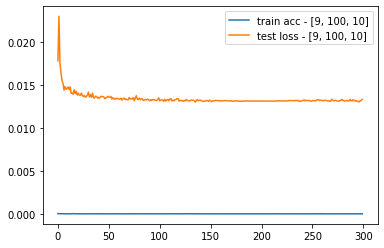

30521

 layers_units [7, 500, 10]


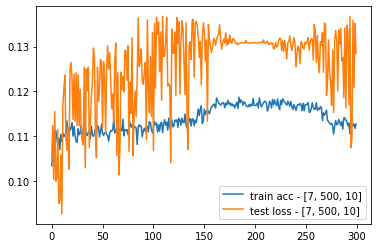

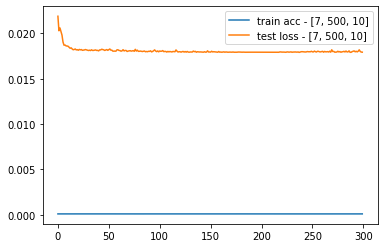

31375

 layers_units [5, 1000, 10]


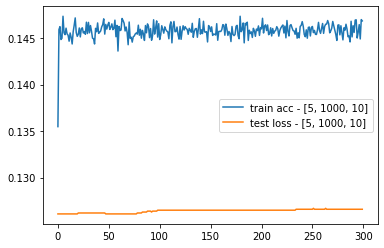

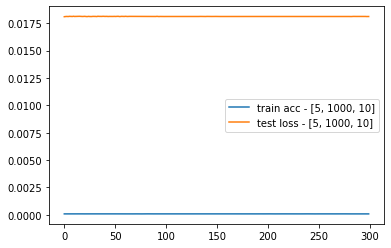

In [ ]:
lr = 0.1
for u2 in [1, 10, 100, 500, 1000]:
    layers_units = compute_layers_first_unit(n_param, 3*32*32, u2, 10)
    print('\n layers_units', layers_units)
    metrics_list = aggregate_metrics(layers_units, epcs)
    plot_metrics(metrics_list)

39983

 layers_units [13, 1, 10]


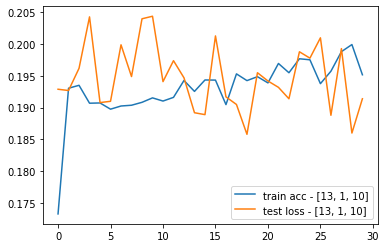

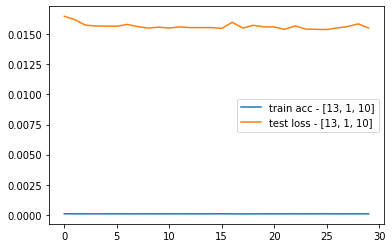

40199

 layers_units [13, 10, 10]


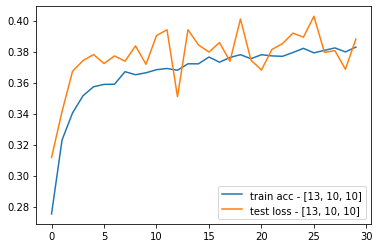

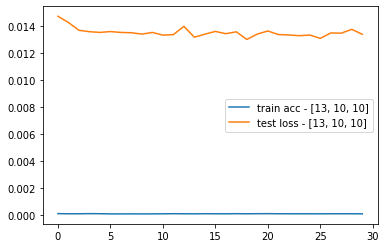

39186

 layers_units [12, 100, 10]


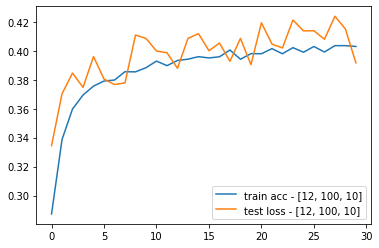

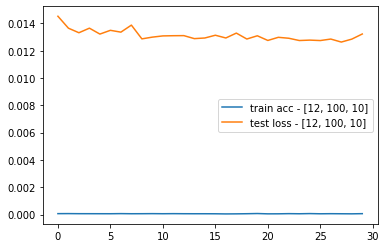

41240

 layers_units [10, 500, 10]


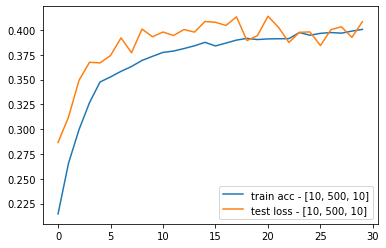

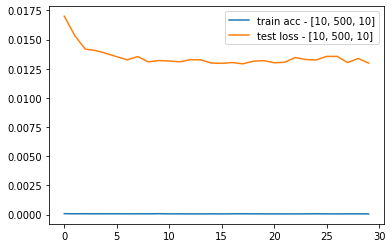

39521

 layers_units [7, 1000, 10]


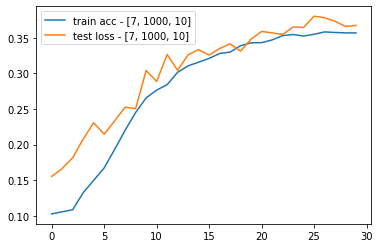

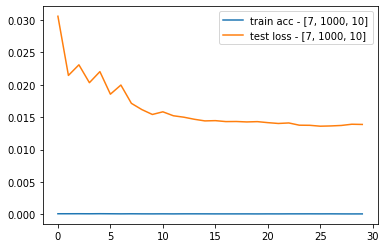

In [ ]:
lr = 0.1
for u2 in [1, 10, 100, 500, 1000]:
    layers_units = compute_layers_first_unit(n_param, 3*32*32, u2, 10)
    print('\n layers_units', layers_units)
    metrics_list = aggregate_metrics(layers_units, epcs)
    plot_metrics(metrics_list)


In [ ]:
def aggregate_avg_metrics(second_units_list, epcs):
    avg_loss, avg_val_loss, avg_acc, avg_val_acc, avg_acc_gap, avg_loss_gap = {}, {}, {}, {}, {}, {}
    for u2 in second_units_list:
        layers_units = compute_layers_first_unit(30000, 3*32*32, u2, 10)
        filename = local_path+'/results/pytorch_cifar10_{}_{}epcs'.format(str(layers_units), epcs)
        if os.path.isfile(filename):
            print("loading checkpoint '{}'".format(filename))
            checkpoint = torch.load(filename)
            avg_loss[str(layers_units)] = np.mean(checkpoint['loss'][:-10]) #TODO change this to take the average on a number of runs
            avg_val_loss[str(layers_units)] = np.mean(checkpoint['val_loss'][:-10]) 
            avg_acc[str(layers_units)] = np.mean(checkpoint['acc'][:-10]) 
            avg_val_acc[str(layers_units)] = np.mean(checkpoint['val_acc'][:-10]) 
            avg_acc_gap[str(layers_units)] = np.mean(checkpoint['acc'][:-10]) - np.mean(checkpoint['val_acc'][:-10]) 
            avg_loss_gap[str(layers_units)] =  np.mean(checkpoint['val_loss'][:-10])  -  np.mean(checkpoint['loss'][:-10]) 
        else:
            print("checkpoint not found '{}'".format(filename))

    return avg_loss, avg_val_loss, avg_acc, avg_val_acc, avg_acc_gap, avg_loss_gap



In [ ]:
def plot_avg_metrics(second_units_list, metric_dict, label):
    y=[]
    for layers_units in metric_dict:
        y.append(metric_dict[str(layers_units)])
    plt.plot(second_units_list, y, 'o-', label=label)
    plt.xticks(second_units_list, second_units_list) 
    plt.legend()
    #plt.show()

In [ ]:
avg_loss, avg_val_loss, avg_acc, avg_val_acc, avg_acc_gap, avg_loss_gap = aggregate_avg_metrics([1, 10, 100, 1000], 200)


30761
loading checkpoint '/home/mm/research/bottleneck_experiments//results/pytorch_cifar10_[10, 1, 10]_200epcs'
30950
loading checkpoint '/home/mm/research/bottleneck_experiments//results/pytorch_cifar10_[10, 10, 10]_200epcs'
29667
loading checkpoint '/home/mm/research/bottleneck_experiments//results/pytorch_cifar10_[9, 100, 10]_200epcs'
31375
loading checkpoint '/home/mm/research/bottleneck_experiments//results/pytorch_cifar10_[5, 1000, 10]_200epcs'


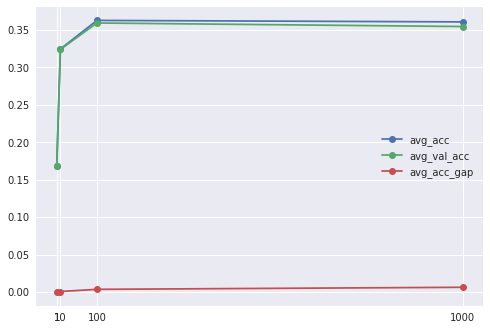

In [ ]:
plot_avg_metrics([1, 10, 100, 1000], avg_acc, 'avg_acc')
plot_avg_metrics([1, 10, 100, 1000], avg_val_acc, 'avg_val_acc')
plot_avg_metrics([1, 10, 100, 1000], avg_acc_gap, 'avg_acc_gap')

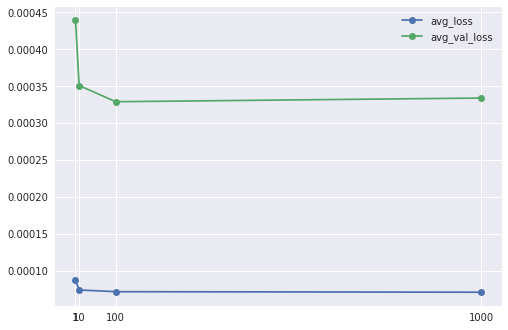

In [ ]:
plot_avg_metrics([1, 10, 100, 1000], avg_loss, 'avg_loss')
plot_avg_metrics([1, 10, 100, 1000], avg_val_loss, 'avg_val_loss')
#plot_avg_metrics([1, 10, 100, 1000], avg_loss_gap, 'avg_loss_gap')

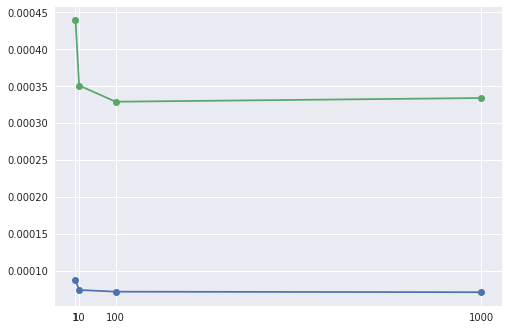

In [ ]:
aplot_avg_metrics([1, 10, 100, 1000], avg_loss)
plot_avg_metrics([1, 10, 100, 1000], avg_val_loss)

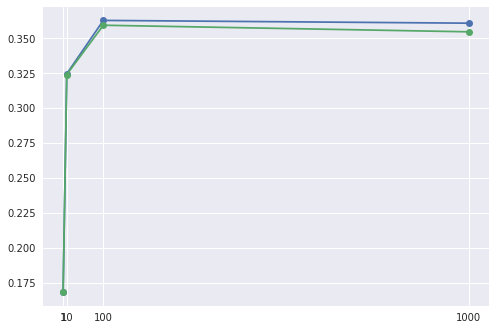

In [ ]:
plot_avg_metrics([1, 10, 100, 1000], avg_acc)
plot_avg_metrics([1, 10, 100, 1000], avg_val_acc)

30761

 layers_units [10, 1, 10]
loading checkpoint '/home/mm/research/bottleneck_experiments//results/pytorch_cifar10_[10, 1, 10]_150epcs'


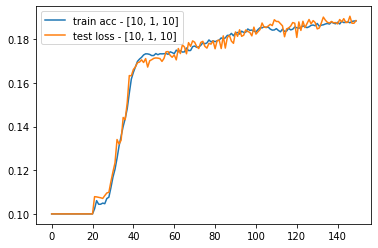

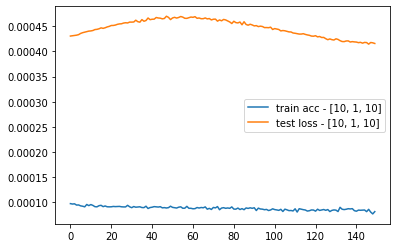

30950

 layers_units [10, 10, 10]
loading checkpoint '/home/mm/research/bottleneck_experiments//results/pytorch_cifar10_[10, 10, 10]_150epcs'


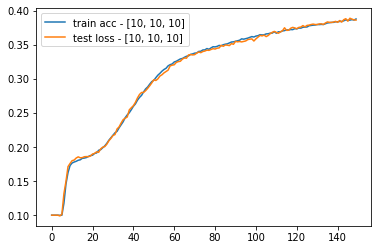

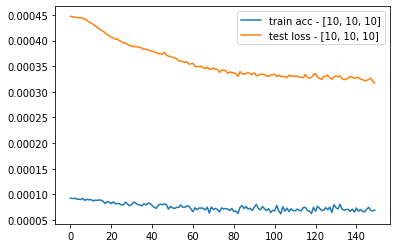

29667

 layers_units [9, 100, 10]
loading checkpoint '/home/mm/research/bottleneck_experiments//results/pytorch_cifar10_[9, 100, 10]_150epcs'


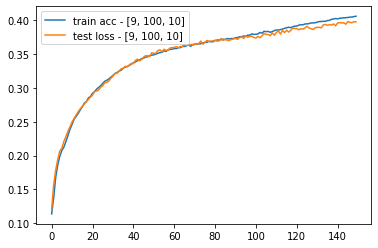

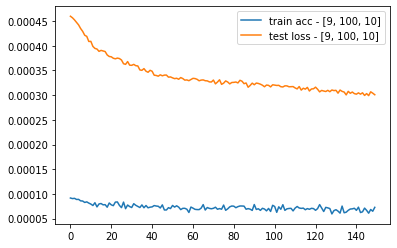

31375

 layers_units [5, 1000, 10]
loading checkpoint '/home/mm/research/bottleneck_experiments//results/pytorch_cifar10_[5, 1000, 10]_150epcs'


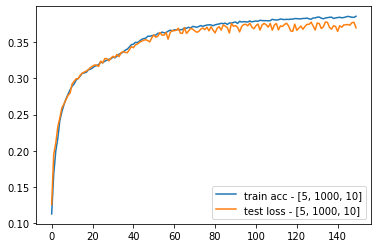

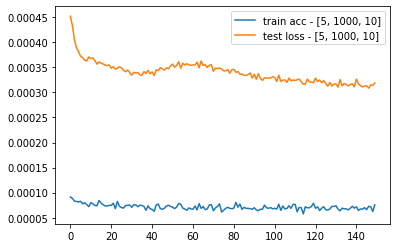

In [ ]:
for u2 in [1, 10, 100, 1000]:
    layers_units = compute_layers_first_unit(30000, 3*32*32, u2, 10)
    print('\n layers_units', layers_units)
    plot_metrics(layers_units, 150)

In [ ]:
layers_units = compute_layers_first_unit(30000, 3*32*32, 10, 10)
net=Net(3*32*32, layers_units)
optimizer = optim.SGD(net.parameters(), lr=0.001)

_, _, _, losses, val_losses, accs, val_accs = load_checkpoint(net, optimizer, filename=model_path)

30950
=> loading checkpoint '/home/mm/research/bottleneck_experiments/results/pytorch_cifar10_[10, 10, 10]_6epcs'
=> loaded checkpoint '/home/mm/research/bottleneck_experiments/results/pytorch_cifar10_[10, 10, 10]_6epcs' (epoch 6)


In [ ]:
accs

[0.10016, 0.10056, 0.10444, 0.12304, 0.13976, 0.1477]

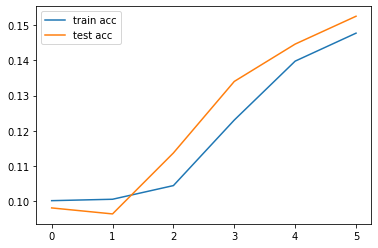

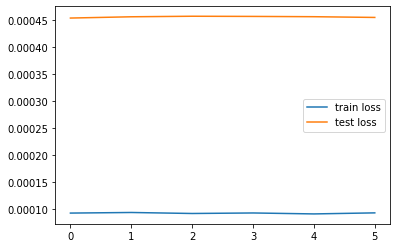

In [ ]:
for i in [1]:
    plt.plot(accs, label='train acc')
    plt.plot(val_accs, label='test acc')
    plt.legend()
    plt.show()
    plt.plot(losses, label='train loss')
    plt.plot(val_losses, label='test loss')
    plt.legend()
    plt.show()

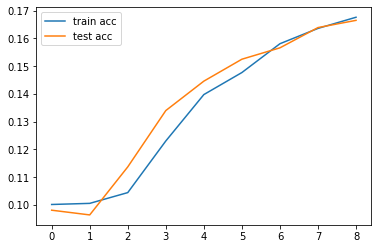

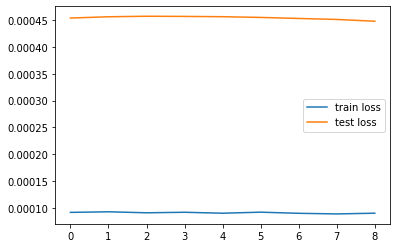

In [ ]:
for key in acc_dict:
    plt.plot(acc_dict[key], label='train acc')
    plt.plot(val_acc_dict[key], label='test acc')
    plt.legend()
    plt.show()
    plt.plot(loss_dict[key], label='train loss')
    plt.plot(val_loss_dict[key], label='test loss')
    plt.legend()
    plt.show()
   